In [12]:
initial_path = 'peptide-QML'
# initial_path = '..'

In [13]:
import sys, random
sys.path.append(initial_path)

%load_ext autoreload
%autoreload 2
from my_code import helper_classes as c
from my_code import pytorch_model as m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
import torch
import torch.nn as nn
import time

class one_hot_encode(nn.Module):
    def __init__(self, num_classes=19):
        super(one_hot_encode, self).__init__()
        self.num_classes = num_classes

    def forward(self, tensor):
        one_hot = torch.zeros(tensor.size(0), tensor.size(1), self.num_classes, device=tensor.device)
        one_hot.scatter_(2, tensor.unsqueeze(-1).long(), 1)
        return one_hot

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        self.embedding = one_hot_encode(19)
        self.lstm = nn.LSTM(19, 64, batch_first=True, num_layers=3)
        self.dense = nn.Sequential(nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 1))
        
    def forward(self, x):
        x = self.embedding(x)
        x, (h, c) = self.lstm(x)
        x = self.dense(h[-1]) # TODO use x[:, -1, :]
        return x


model = MyModel().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

data = c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12_Numbers_int')
data.set_test_ptc(0.2)
data.to('cuda')
data_loader = data.get_loader(batch_size=32, shuffle=True)
len_x = len(data.x_train)

time_start = time.time()
loss_list = []
for epoch in range(100):
    for i, (x, y) in enumerate(data_loader):

        optimizer.zero_grad()
        score = model(x)
        loss = loss_function(score, y)
        loss.backward()
        optimizer.step()

        #time and print
        time_left = (time.time() - time_start) * (100*len_x / ((i+1)*32 + epoch*len_x) - 1) 
        hours = int(time_left // 3600)
        minutes = int((time_left - hours * 3600) // 60)
        seconds = int(time_left - hours * 3600 - minutes * 60)

        #loss
        loss = loss.item()
        loss_list.append(loss)
        print(f'Epoch {epoch}, iter {(i+1)*32}/{len_x}, loss={loss:.4f}, time left={hours}h {minutes}m {seconds}s                                    ', end='\r')

    loss_last_epoch = sum(loss_list[-len_x//32:]) / (len_x//32)
    print(f'Epoch {epoch}, loss={loss_last_epoch:.6f},                                                                                           ', end='\n')



Epoch 0, loss=0.005971,                                                                                           
Epoch 1, loss=0.003712,                                                                                           
Epoch 2, loss=0.003052,                                                                                           
Epoch 3, loss=0.002612,                                                                                           
Epoch 4, loss=0.002288,                                                                                           
Epoch 5, loss=0.002038,                                                                                           
Epoch 6, loss=0.001847,                                                                                           
Epoch 7, loss=0.001698,                                                                                           
Epoch 8, loss=0.001575,                                                         

In [ ]:
pred = model.to('cpu')(data.x_test.to('cpu'))

In [ ]:
loss_val = loss_function(pred, data.y_test.to('cpu'))

In [ ]:
loss_val

tensor(0.0016, grad_fn=<MseLossBackward>)

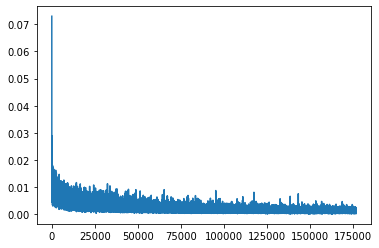

In [ ]:
import matplotlib.pyplot as plt

plt.plot(loss_list)
plt.show()

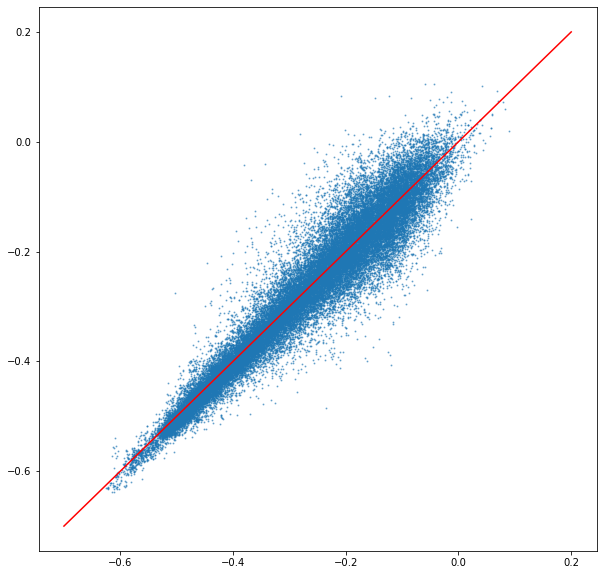

In [ ]:

plt.figure(figsize=(10, 10))
plt.scatter(pred.detach().numpy(), data.y_test.to('cpu').detach().numpy(), s=1, alpha=0.5)
# 1 to 1 line
plt.plot([-0.7, 0.2], [-0.7, 0.2], color='red')
plt.show()

In [ ]:
import torch
import torch.nn as nn
import time

class MyModel(nn.Module):
    def __init__(self, emb_dim):
        super(MyModel, self).__init__()
        
        self.embedding = nn.Embedding(19, emb_dim)
        self.lstm1 = nn.LSTM(emb_dim, 64, batch_first=True, num_layers=1)
        self.lstm2 = nn.LSTM(64, 64, batch_first=True, num_layers=3)
        self.dense = nn.Sequential(nn.Linear(64, 64), nn.ReLU(), nn.Linear(64, 1))
        
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.dense(x[:, -1, :])
        return x


model = MyModel(32).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

data = c.Data.load(initial_path=initial_path, file_name='PET_SCORES_12_Numbers_int')
data.set_test_ptc(0.2)
data.to('cuda')
data_loader = data.get_loader(batch_size=32, shuffle=True)
len_x = len(data.x_train)

time_start = time.time()
loss_list = []
for epoch in range(100):
    for i, (x, y) in enumerate(data_loader):

        optimizer.zero_grad()
        score = model(x)
        loss = loss_function(score, y)
        loss.backward()
        optimizer.step()

        #time and print
        time_left = (time.time() - time_start) * (100*len_x / ((i+1)*32 + epoch*len_x) - 1) 
        hours = int(time_left // 3600)
        minutes = int((time_left - hours * 3600) // 60)
        seconds = int(time_left - hours * 3600 - minutes * 60)

        #loss
        loss = loss.item()
        loss_list.append(loss)
        print(f'Epoch {epoch}, iter {(i+1)*32}/{len_x}, loss={loss:.4f}, time left={hours}h {minutes}m {seconds}s                                    ', end='\r')

    loss_last_epoch = sum(loss_list[-len_x//32:]) / (len_x//32)
    print(f'Epoch {epoch}, loss={loss_last_epoch:.6f},                                                                                           ', end='\n')



Epoch 0, loss=0.005276,                                                                                           
Epoch 1, loss=0.003253,                                                                                           
Epoch 2, loss=0.002632,                                                                                           
Epoch 3, loss=0.002250,                                                                                           
Epoch 4, loss=0.001987,                                                                                           
Epoch 5, loss=0.001784,                                                                                           
Epoch 6, loss=0.001634,                                                                                           
Epoch 7, loss=0.001523,                                                                                           
Epoch 8, loss=0.001426,                                                         

KeyboardInterrupt: 